In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
import os
import toolz
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import datetime

from glob import glob

import pandas as pd
from tqdm.notebook import tqdm

try:
    dir_changed
except:
    os.chdir('..')
    dir_changed = True

import config as cfg
import src.utils as utils

from src.loaders import CSVLoader

In [50]:
loader = CSVLoader()

In [51]:
loader.data_manager.list_available_machines()["raw"]

['WOS 176L',
 'LK3 046L',
 'WOS 175L',
 'LK3 050L',
 'LK3 045L',
 'WOS 179L',
 'LK3 048L',
 'WOS 177L',
 'WOS 174L']

In [110]:
from src.add_features import CorrelationFinder, FeatureManager, VarianceCalculator, OutlierFinder, BreakTimer

In [89]:
fm = FeatureManager(machine_id='WOS 176L')

/home/ubuntu/anaconda3/envs/audioburst/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [113]:
cor_f = CorrelationFinder(feature_pairs =[("HYDOILP", "HYDOILT"),("HYDOILP", "TEMPIN")], freq="600s")
vc = VarianceCalculator(feature_name="HYDOILP", freq="600s")
of = OutlierFinder(feature_pairs =[("HYDOILP", "TEMPIN")], freq="600s")
bt = BreakTimer()

In [136]:
of = OutlierFinder(feature_pairs =[("HYDOILP", "TEMPIN")], freq="600s")
pd.concat([of.calculate_feature(fm.loader.all_data["middle"]).query("outlier_HYDOILP_TEMPIN == 1").head(10),of.calculate_feature(fm.loader.all_data["middle"]).query("outlier_HYDOILP_TEMPIN == 0").head(10)]).sample(frac=1)

czas  outlier_HYDOILP_TEMPIN
3    2019-11-02 06:50:00                       0
4    2019-11-02 07:00:00                       0
1526 2019-11-12 20:40:00                       1
6    2019-11-02 07:20:00                       0
1525 2019-11-12 20:30:00                       1
5    2019-11-02 07:10:00                       0
7    2019-11-02 07:30:00                       0
31   2019-11-02 11:30:00                       1
2    2019-11-02 06:40:00                       0
9    2019-11-02 07:50:00                       0
0    2019-11-02 06:20:00                       0
1    2019-11-02 06:30:00                       0
32   2019-11-02 11:40:00                       1
1537 2019-11-12 22:30:00                       1
1547 2019-11-13 00:10:00                       1
1527 2019-11-12 20:50:00                       1
377  2019-11-04 21:10:00                       1
1524 2019-11-12 20:20:00                       1
510  2019-11-05 19:20:00                       1
8    2019-11-02 07:40:00                       0

In [114]:
bt.calculate_feature(fm.loader.all_data["middle"])

czas  czas_od_postoju
0       2019-11-02 06:24:20                0
1       2019-11-02 06:24:21                1
2       2019-11-02 06:24:22                2
3       2019-11-02 06:24:23                3
4       2019-11-02 06:24:24                4
...                     ...              ...
4247496 2020-01-31 20:39:06           421706
4247497 2020-01-31 20:39:07           421707
4247498 2020-01-31 20:39:08           421708
4247499 2020-01-31 20:39:09           421709
4247500 2020-01-31 20:39:10           421710

[4247501 rows x 2 columns]

In [112]:
tt = fm.loader.all_data["middle"].copy()

In [94]:
tt["bigger_stop"] = np.nan

In [96]:
tt.loc[(tt["czas"].diff() > datetime.timedelta(days=1)).dropna(),"bigger_stop"] = tt.loc[(tt["czas"].diff() > datetime.timedelta(days=1)).dropna(),"czas"]

In [100]:
tt["bigger_stop"] = tt["bigger_stop"].fillna(method="ffill").fillna(tt["czas"].loc[0])

In [106]:
(tt["czas"] - tt["bigger_stop"])

0         0 days 00:00:00
1         0 days 00:00:01
2         0 days 00:00:02
3         0 days 00:00:03
4         0 days 00:00:04
                ...      
4247496   4 days 21:08:26
4247497   4 days 21:08:27
4247498   4 days 21:08:28
4247499   4 days 21:08:29
4247500   4 days 21:08:30
Length: 4247501, dtype: timedelta64[ns]

In [108]:
(tt["czas"] - tt["bigger_stop"]).dt.days * (60 * 60 * 24) + (tt["czas"] - tt["bigger_stop"]).dt.seconds

0               0
1               1
2               2
3               3
4               4
            ...  
4247496    421706
4247497    421707
4247498    421708
4247499    421709
4247500    421710
Length: 4247501, dtype: int64

### Outliers

In [115]:
from pyod.models.cblof import CBLOF
from pyod.models.pca import PCA

class CBLOFOutlier:
    
    def __init__(self, outliers_fraction):
        self.outliers_fraction = outliers_fraction
        self.clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)

    def find_outliers(self, data_to_train, data_to_detect, feature1, feature2, plot=False):
        
        self.clf.fit(data_to_train[[feature1, feature2]].dropna().values)
        
        data_to_detect = data_to_detect[[feature1, feature2]].dropna().copy()
        
        scores_pred = self.clf.decision_function(data_to_detect) * -1
        y_pred = self.clf.predict(data_to_detect)
        
        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)
        data_to_detect["outlier"] = y_pred
    
    
        if plot:
            plt.figure(figsize=(10, 10))

            xx , yy = np.meshgrid(np.linspace(data_to_detect[feature1].min(), data_to_detect[feature1].max(), 100), np.linspace(data_to_detect[feature2].min(), data_to_detect[feature2].max(), 100))

            inliers_sales = np.array(data_to_detect[feature1][data_to_detect['outlier'] == 0]).reshape(-1,1)
            inliers_profit = np.array(data_to_detect[feature2][data_to_detect['outlier'] == 0]).reshape(-1,1)

            # sales - outlier feature 1, profit - outlier feature 2
            outliers_sales = data_to_detect[feature1][data_to_detect['outlier'] == 1].values.reshape(-1,1)
            outliers_profit = data_to_detect[feature2][data_to_detect['outlier'] == 1].values.reshape(-1,1)

            print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
            threshold = np.percentile(scores_pred, 100 * self.outliers_fraction)    
            Z = self.clf.decision_function(np.c_[xx.ravel(), yy.ravel()])  * -1 
            Z = Z.reshape(xx.shape)

            plt.contourf(xx, yy, Z, levels= np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)

            a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
            plt.contourf(xx, yy, Z, levels= [threshold, Z.max()],colors='orange')
            b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')

            c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')

            plt.xlabel(feature1)
            plt.ylabel(feature2)

            plt.axis('tight')   
            plt.legend([a.collections[0], b,c], ['Stworzona funkcja odrzucania outlierów', 'dobre dane','outliery'],
                       prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      

            plt.show()
        
        return data_to_detect["outlier"]
    
    
class PCAOutlier:
    
    def __init__(self, outliers_fraction):
        self.outliers_fraction = outliers_fraction
        self.clf = PCA(contamination=outliers_fraction, random_state=0)

    def find_outliers(self, data_to_train, data_to_detect, feature1, feature2):
        
        self.clf.fit(data_to_train[[feature1, feature2]].dropna().values)
        
        data_to_detect = data_to_detect[[feature1, feature2]].dropna().copy()
        
        scores_pred = self.clf.decision_function(data_to_detect) * -1
        y_pred = self.clf.predict(data_to_detect)
        
        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)
        
        data_to_detect["outlier"] = y_pred
        plt.show()
        
        return data_to_detect["outlier"]

In [116]:
outlier = CBLOFOutlier(outliers_fraction=0.005)

OUTLIERS: 1381 INLIERS: 279069


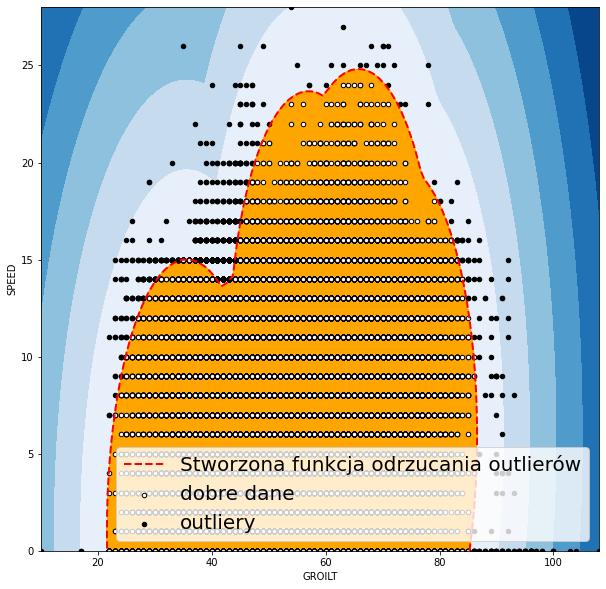

600        0
615        0
630        0
645        0
660        0
          ..
4247435    0
4247450    0
4247465    0
4247480    0
4247495    0
Name: outlier, Length: 280450, dtype: int64

In [123]:
outlier.find_outliers(fm.loader.all_data["middle"], fm.loader.all_data["middle"], "GROILT","SPEED", plot=True)

OUTLIERS: 1404 INLIERS: 281846


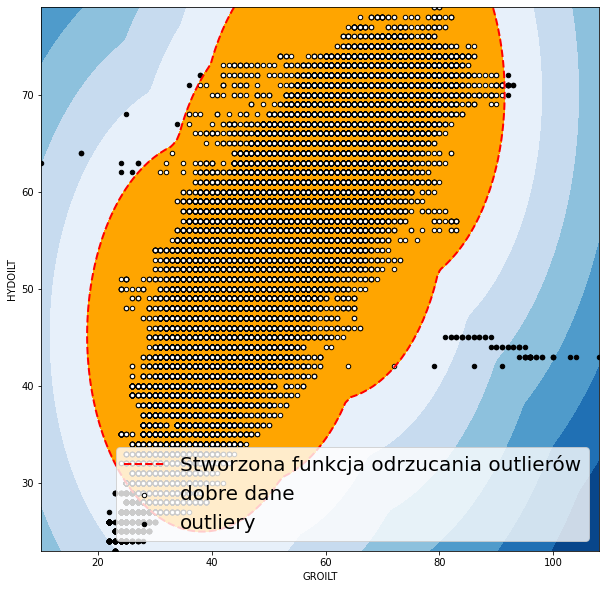

0          1
15         1
30         1
45         1
60         1
          ..
4247435    0
4247450    0
4247465    0
4247480    0
4247495    0
Name: outlier, Length: 283250, dtype: int64

In [138]:
outlier.find_outliers(fm.loader.all_data["middle"], fm.loader.all_data["middle"], "GROILT","HYDOILT", plot=True)

In [128]:
utils.get_time_grouped_data(fm.loader.all_data["middle"], freq="600s").head(20)

BREAKP   ENGCOOLT  ENGHOURS     ENGOILP  \
czas                                                                 
2019-11-02 06:20:00   8794.117647        NaN       NaN         NaN   
2019-11-02 06:30:00   4455.666667  58.956522     715.0  345.043478   
2019-11-02 06:40:00   9380.500000  84.000000       NaN    0.000000   
2019-11-02 06:50:00  10224.500000  84.000000     715.0    0.000000   
2019-11-02 07:00:00  10189.833333  79.125000     715.0    0.000000   
2019-11-02 07:10:00   1362.833333  84.350000       NaN  339.141667   
2019-11-02 07:20:00    322.500000  89.525000     715.0  372.000000   
2019-11-02 07:30:00    191.500000  88.675000     715.0  372.000000   
2019-11-02 07:40:00    520.500000  87.725000       NaN  372.000000   
2019-11-02 07:50:00   1436.333333  87.425000     715.0  372.000000   
2019-11-02 08:00:00   2563.333333  88.225000     716.0  372.000000   
2019-11-02 08:10:00    441.833333  91.200000       NaN  372.000000   
2019-11-02 08:20:00   1711.166667  90.820513     716.0  372.000000   
2019-11-02 08:30:00   1968.666667  89.700000     716.0  372.000000   
2019-11-02 08:40:00    848.166667  88.575000       NaN  372.000000   
2019-11-02 08:50:00    573.666667  90.975000     716.0  372.000000   
2019-11-02 09:00:00   1508.500000  88.225000     717.0  372.000000   
2019-11-02 09:10:00    843.000000  92.150000       NaN  364.566667   
2019-11-02 09:20:00   1756.166667  89.725000     717.0  372.000000   
2019-11-02 09:30:00    857.666667  90.275000     717.0  372.000000   

                          ENGRPM     ENGTPS  ERROR     FUELUS       GROILP  \
czas                                                                         
2019-11-02 06:20:00          NaN   0.000000    NaN        NaN     0.000000   
2019-11-02 06:30:00  1175.971347  16.776667    NaN  12.787966   932.373333   
2019-11-02 06:40:00     0.000000   0.000000    NaN   0.000000     0.000000   
2019-11-02 06:50:00     0.000000   0.000000    NaN   0.000000     0.000000   
2019-11-02 07:00:00     0.000000   0.000000    NaN   0.000000     0.000000   
2019-11-02 07:10:00  1392.611667  41.410000    NaN  15.040000  1636.240000   
2019-11-02 07:20:00  1678.433333  54.611667    NaN  21.888333  1787.520000   
2019-11-02 07:30:00  1734.070000  55.025000    NaN  14.945000  1789.093333   
2019-11-02 07:40:00  1145.658333  21.363333    NaN   7.018333  1734.597663   
2019-11-02 07:50:00  1049.351667  16.823333    NaN   6.245000  1730.266667   
2019-11-02 08:00:00  1280.291667  35.775000    NaN  15.561667  1749.128548   
2019-11-02 08:10:00  1830.760000  65.356667    NaN  21.583333  1811.200000   
2019-11-02 08:20:00  1652.276667  59.078333    NaN  24.305000  1789.200000   
2019-11-02 08:30:00  1538.478333  46.355000    NaN  13.260000  1770.906667   
2019-11-02 08:40:00  1279.628333  35.878333    NaN  15.738333  1746.506667   
2019-11-02 08:50:00  1776.536667  60.741667    NaN  19.876667  1802.586667   
2019-11-02 09:00:00  1291.188333  32.908333    NaN  11.546667  1744.133333   
2019-11-02 09:10:00  1887.575000  72.788333    NaN  25.536667  1791.733333   
2019-11-02 09:20:00  1502.331667  50.190000    NaN  19.496667  1769.546667   
2019-11-02 09:30:00  1635.050000  51.455000    NaN  14.641667  1781.200000   

                        GROILT  ...   HYDOILP  HYDOILT     INTAKEP    INTAKET  \
czas                            ...                                             
2019-11-02 06:20:00  25.000000  ...  0.000647   26.000         NaN        NaN   
2019-11-02 06:30:00  26.500000  ...  1.656933   26.450   58.521739  33.086957   
2019-11-02 06:40:00  32.794872  ...  1.194050   28.000    0.000000  33.000000   
2019-11-02 06:50:00  32.350000  ...  0.500833   28.000    0.000000  33.000000   
2019-11-02 07:00:00  31.125000  ...  0.343800   28.000    0.000000  48.100000   
2019-11-02 07:10:00  35.225000  ...  0.294267   30.250   71.633333  48.550000   
2019-11-02 07:20:00  44.300000  ...  0.388083   38.125  121.316667  56.625000   
2019-11-02 07:30:00  48.575000  ...  0.4